# Evaluación de la segmentación

In [1]:
import cv2 as cv # ver. 4.5.5
from matplotlib import pyplot as plt

In [2]:
imc_07c = cv.imread('im/07c.jpg') # +5
imc_09d = cv.imread('im/09d.png') # +1
imc_10c = cv.imread('im/10c.jpg') # +1
imc_10t = cv.imread('im/10t.jpg') # +2
imc_all = cv.imread('im/all.png') # +4
imc_cyd = cv.imread('im/cyd.jpg') # +52

In [3]:
img_07c = cv.imread('im/07c.jpg', cv.IMREAD_GRAYSCALE) # Bien
img_09d = cv.imread('im/09d.png', cv.IMREAD_GRAYSCALE) # +1
img_10c = cv.imread('im/10c.jpg', cv.IMREAD_GRAYSCALE) # Bien
img_10t = cv.imread('im/10t.jpg', cv.IMREAD_GRAYSCALE) # +2
img_all = cv.imread('im/all.png', cv.IMREAD_GRAYSCALE) # +4
img_cyd = cv.imread('im/cyd.jpg', cv.IMREAD_GRAYSCALE) # +2

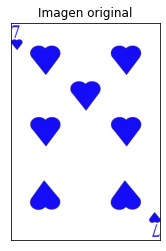

In [4]:
im = imc_07c
plt.imshow(im)
plt.title("Imagen original"), plt.xticks([]), plt.yticks([])
plt.show()

Una vez que seleccionamos una imagen en escala de grises, es posible obtener una imagen binaria con los bordes claramente identificados gracias al algoritmo de Canny.

In [5]:
# Los números son las intensidades min y máx para identificar el borde
canny = cv.Canny(im, 25, 100)
cv.imwrite('out/canny.jpg', canny)

True

Ver [Este enlace](https://circuitdigest.com/tutorial/image-segmentation-using-opencv) sobre segmentación y la documentación oficial de la [version 4.5.5 de opencv](https://docs.opencv.org/4.5.5/d4/d73/tutorial_py_contours_begin.html). El comando `cv.findContours()` encuentra los contornos en una imagen binaria (primer parámetro). Debe especificarse el algoritmo que usará para encontrar los contornos (segundo parámetro):

- `RETR_EXTERNAL`: Detecta solo los bordes más externos.
- `RETR_LIST`: Detecta todos los contornos.
- `RETR_CCOMP` y `RETR_TREE`: Detectan todos los bordes y establecen alguna jerarquía entre ellos.

El último parámetro establece el método de aproximación para el contorno, los principales son:

- `CHAIN_APPROX_NONE`: Almacena absolutamente todos los puntos de contorno.
- `CHAIN_APPROX_SIMPLE`: Comprime segmentos horizontales, verticales y diagonales y deja sólo sus puntos finales.

Al cambiar este último parámetro no se han observado cambios en el resultado.

Por su parte el comando `drawContours()` dibujará los contornos sobre la imagen original (primer parámetro); para ello debe acceder a los contornos previamente obtenidos (segundo parámetro). El tercer parámetro es aquel contorno específico a dibujar, `-1` significa todos. Los parámetros siguientes serán el color del contorno y su grosor.

In [6]:
contours, hierarchy = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
out = cv.drawContours(im, contours, -1, (64,255,64), 3)
cv.imwrite('out/out.jpg', out)
print('Número de contornos encontrados: ', len(contours))

Número de contornos encontrados:  16


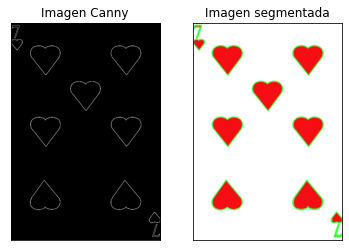

In [7]:
#im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
canny = cv.cvtColor(canny, cv.COLOR_BGR2RGB)
out = cv.cvtColor(out, cv.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(canny)
plt.title('Imagen Canny'), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(out)
plt.title('Imagen segmentada'), plt.xticks([]), plt.yticks([])
plt.show()

Como puede observarse en la imagen, los contornos son dibujados propiamente, sin embargo, el número de contornos puede no coincidir con el número de objetos en la imagen. Cuando se usan imágenes con cartas de corazones los elementos coinciden con los contornos. sin embargo los treboles debido a lo angosto de una parte del dibujo pueden ser identificados como dos objetos y no como uno.